In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
from pu_criterion.non_pu_classification import LDA, LogRegression
from scipy.stats import ttest_rel, ttest_ind

In [3]:
def read_results(directory):
    models = os.listdir(directory)
    rows = []
    for model in models:
        try:
            row = {'name':model}
            infos = model.split('_')
            row['rdm_state'] = int(infos[2])
        except:
            continue
        try:
            row['sampling_factor'] = int(infos[3])
        except:
            row['sampling_factor'] = 0
        row['ne'] = infos[1]
        row['nc'] = infos[0]
        row['balanced'] = infos[-1]
        scores = json.load(open('{}/{}/results.json'.format(directory, model), 'r'))
        row['ROC_AUC'], row['PR_AUC'], row['Recall'], row['Precision'], row['F1'] = scores['ROC AUC'], scores['PR AUC'], scores['Recall'], scores['Precision'], scores['F1']
        base_scores = json.load(open('{}/{}/base_results.json'.format(directory, model), 'r'))
        row['ROC_AUC_base'], row['PR_AUC_base'], row['Recall_base'], row['Precision_base'], row['F1_base'] = base_scores['ROC AUC'], base_scores['PR AUC'], base_scores['Recall'], base_scores['Precision'], base_scores['F1']
        base_cscores = json.load(open('{}/{}/base_cresults.json'.format(directory, model), 'r'))
        row['ROC_AUC_base_c'], row['PR_AUC_base_c'], row['Recall_base_c'], row['Precision_base_c'], row['F1_base_c'] = base_cscores['ROC AUC'], base_cscores['PR AUC'], base_cscores['Recall'], base_cscores['Precision'], base_cscores['F1']
        scores_c = json.load(open('{}/{}/cresults.json'.format(directory, model), 'r'))
        row['ROC_AUC_c'], row['PR_AUC_c'], row['Recall_c'], row['Precision_c'], row['F1_c'] = scores_c['ROC AUC'], scores_c['PR AUC'], scores_c['Recall'], scores_c['Precision'], scores_c['F1']
        scores_DV = json.load(open('{}/{}/DVresults.json'.format(directory, model), 'r'))
        row['ROC_AUC_DV'], row['PR_AUC_DV'], row['Recall_DV'], row['Precision_DV'], row['F1_DV'] = scores_DV['ROC AUC'], scores_DV['PR AUC'], scores_DV['Recall'], scores_DV['Precision'], scores_DV['F1']
        scores_DV_c = json.load(open('{}/{}/DVcresults.json'.format(directory, model), 'r'))
        row['ROC_AUC_DV_c'], row['PR_AUC_DV_c'], row['Recall_DV_c'], row['Precision_DV_c'], row['F1_DV_c'] = scores_DV_c['ROC AUC'], scores_DV_c['PR AUC'], scores_DV_c['Recall'], scores_DV_c['Precision'], scores_DV_c['F1']
        rows.append(row)
    return pd.DataFrame(rows)

In [4]:
def results_table(res, metric , a='both', ax=None):
    s1 = res[metric]
    s2 = res[metric+'_base']
    s3 = res[metric+'_DV']
    s4 = res[metric+'_c']
    s5 = res[metric+'_base'+'_c']
    s6 = res[metric+'_DV'+'_c']
    if metric == 'ROC_AUC':
        color='blue'
    elif metric == 'PR_AUC':
        color='orange'
    if a=='both':
        if ax is None:
            plt.boxplot([s1, s2, s3, s4, s5, s6], labels=[r'PU ($\eta\times e$)', r'LR ($\eta\times e$)', r'DV ($\eta\times e$)', r'PU ($\eta$)', r'LR ($\eta$)', r'DV ($\eta$)'])
            # plt.hlines(0.5, xmin=0, xmax=5, linestyle='dashed')
        else:
            ax.boxplot([s1, s2, s3, s4, s5, s6], labels=[r'PU ($\eta\times e$)', r'LR ($\eta\times e$)', r'DV ($\eta\times e$)', r'PU ($\eta$)', r'LR ($\eta$)', r'DV ($\eta$)'])
            # ax.hlines(0.5, xmin=0, xmax=5, linestyle='dashed')    
            ax.tick_params(axis='x', labelsize=20)
    elif a=='c':
        if ax is None:
            plt.boxplot([s4, s5, s6], labels=[r'PU ($\eta$)', r'LR ($\eta$)', r'DV ($\eta$)'])
            # plt.hlines(0.5, xmin=0, xmax=5, linestyle='dashed')
        else:
            ax.boxplot([s4, s5, s6], labels=[r'PU ($\eta$)', r'LR ($\eta$)', r'DV ($\eta$)'], boxprops=dict(facecolor=color, color='black', hatch='/', edgecolor='black', alpha=1),
                capprops=dict(color=color),
                whiskerprops=dict(color=color),
                flierprops=dict(color=color, markeredgecolor=color),
                medianprops=dict(color='black'), patch_artist=True)
            # ax.hlines(0.5, xmin=0, xmax=5, linestyle='dashed')      
            ax.tick_params(axis='x', labelsize=20)
    else:
        if ax is None:
            plt.boxplot([s1, s2, s3], labels=[r'PU ($\eta\times e$)', r'LR ($\eta\times e$)', r'DV ($\eta\times e$)'])
            # plt.hlines(0.5, xmin=0, xmax=5, linestyle='dashed')
        else:
            ax.boxplot([s1, s2, s3], labels=[r'PU ($\eta\times e$)', r'LR ($\eta\times e$)', r'DV ($\eta\times e$)'], 
                boxprops=dict(facecolor=color, color='black', hatch='/', edgecolor='black', alpha=1),
                capprops=dict(color=color),
                whiskerprops=dict(color=color),
                flierprops=dict(color=color, markeredgecolor=color),
                medianprops=dict(color='black'), patch_artist=True)
            # ax.hlines(0.5, xmin=0, xmax=5, linestyle='dashed')   
            ax.tick_params(axis='x', labelsize=15)

def results_impr(res, metric, a='both', ax=None):
    s1 = res[metric]-res[metric+'_DV']
    s2 = res[metric]-res[metric+'_base']
    s3 = res[metric+'_c']-res[metric+'_DV'+'_c']
    s4 = res[metric+'_c']-res[metric+'_base'+'_c']
    if metric == 'ROC_AUC':
        color='blue'
    elif metric == 'PR_AUC':
        color='orange'
    if a=='both':
        if ax is None:
            plt.boxplot([s1, s2, s3, s4], labels=[r'PU/DV ($\eta\times e$)', r'PU/LR ($\eta\times e$)', r'PU/DV ($\eta$)', r'PU/LR ($\eta$)'])
            plt.hlines(0, xmin=0, xmax=5, linestyle='dashed')
        else:
            ax.boxplot([s1, s2, s3, s4], labels=[r'PU/DV ($\eta\times e$)', r'PU/LR ($\eta\times e$)', r'PU/DV ($\eta$)', r'PU/LR ($\eta$)'],
                boxprops=dict(facecolor=color, color='black', hatch='/', edgecolor='black', alpha=1),
                capprops=dict(color=color),
                whiskerprops=dict(color=color),
                flierprops=dict(color=color, markeredgecolor=color),
                medianprops=dict(color='black'), patch_artist=True)
            ax.hlines(0, xmin=0, xmax=5, linestyle='dashed')  
            ax.tick_params(axis='x', labelsize=20)
    elif a=='c':
        if ax is None:
            plt.boxplot([s3, s4], labels=[r'PU/DV ($\eta$)', r'PU/LR ($\eta$)'])
            plt.hlines(0, xmin=0, xmax=3, linestyle='dashed')
        else:
            ax.boxplot([s3, s4], labels=[r'PU/DV ($\eta$)', r'PU/LR ($\eta$)'],
            boxprops=dict(facecolor=color, color='black', hatch='/', edgecolor='black', alpha=1),
                capprops=dict(color=color),
                whiskerprops=dict(color=color),
                flierprops=dict(color=color, markeredgecolor=color),
                medianprops=dict(color='black'), patch_artist=True)
            ax.hlines(0, xmin=0, xmax=3, linestyle='dashed') 
            ax.tick_params(axis='x', labelsize=20)
    else:
        if ax is None:
            plt.boxplot([s1, s2], labels=[r'PU/DV ($\eta\times e$)', r'PU/LR ($\eta\times e$)'])
            plt.hlines(0, xmin=0, xmax=3, linestyle='dashed')
        else:
            ax.boxplot([s1, s2], labels=[r'PU/DV ($\eta\times e$)', r'PU/LR ($\eta\times e$)'],
            boxprops=dict(facecolor=color, color='black', hatch='/', edgecolor='black', alpha=1),
                capprops=dict(color=color),
                whiskerprops=dict(color=color),
                flierprops=dict(color=color, markeredgecolor=color),
                medianprops=dict(color='black'), patch_artist=True)
            ax.hlines(0, xmin=0, xmax=3, linestyle='dashed') 
            ax.tick_params(axis='x', labelsize=20)

In [5]:
model_lr = read_results("experiments/pu_experiments/")

# Experiment results with additional variables

Again, several features are accounted for in the classification model while only test conditions are accounted for in the propensity model.

The cell below reproduces figure 11 from the article.

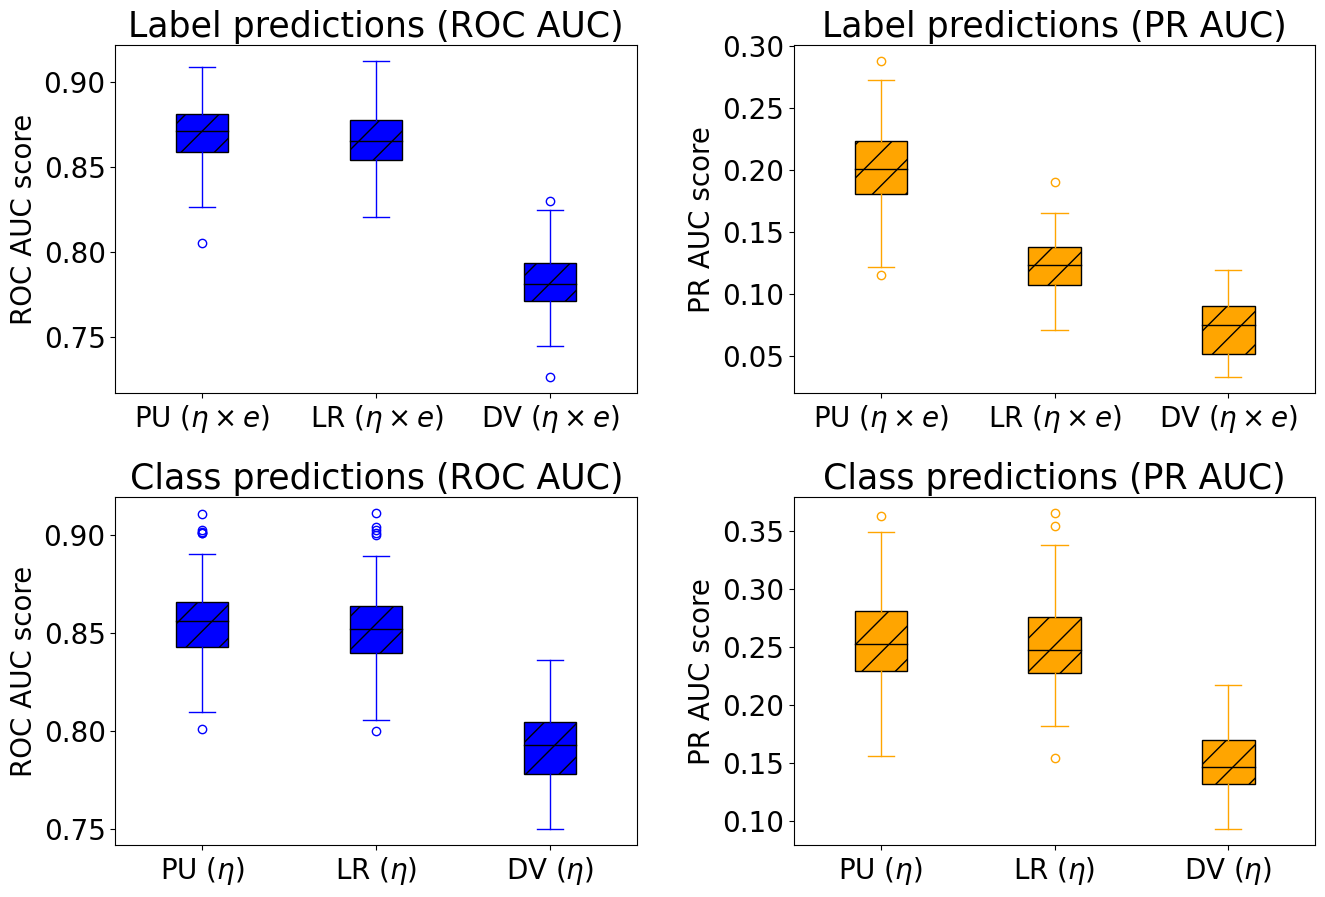

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
results_table(model_lr, 'ROC_AUC', ax=axes[0,0], a='nc')
axes[0,0].set_ylabel('ROC AUC score', fontsize=20)
axes[0,0].tick_params(axis='both', which='major', labelsize=20)
axes[0,0].set_title(r'Label predictions (ROC AUC)', fontsize=25)
results_table(model_lr, 'PR_AUC', ax=axes[0,1], a='nc')
axes[0,1].set_title(r'Label predictions (PR AUC)', fontsize=25)
axes[0,1].set_ylabel('PR AUC score', fontsize=20)
axes[0,1].tick_params(axis='both', which='major', labelsize=20)

results_table(model_lr, 'ROC_AUC', ax=axes[1,0], a='c')
axes[1,0].set_ylabel('ROC AUC score', fontsize=20)
axes[1,0].set_title(r'Class predictions (ROC AUC)', fontsize=25)
axes[1,0].tick_params(axis='both', which='major', labelsize=20)
results_table(model_lr, 'PR_AUC', ax=axes[1,1], a='c')
axes[1,1].set_title(r'Class predictions (PR AUC)', fontsize=25)
axes[1,1].set_ylabel('PR AUC score', fontsize=20)
axes[1,1].tick_params(axis='both', which='major', labelsize=20)
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.3)
plt.savefig('figures/PU_model_performances.png', bbox_inches='tight')

## T-test to check the difference of performances between PU and other models

In [7]:
def ttests(df):
    rows = []
    for eval in ['', '_c']:
        for metric in ['ROC_AUC', 'PR_AUC']:
            row = {}
            row['index'] = (eval, metric)
            row[('PU_DV','stat')], row[('PU_DV','pval')] = ttest_rel(df[metric+eval], df[metric+'_DV'+eval],alternative='greater')
            row[('PU_LR','stat')], row[('PU_LR','pval')] = ttest_rel(df[metric+eval], df[metric+'_base'+eval],alternative='greater')
            rows.append(row)
    res = pd.DataFrame(rows)
    res.set_index('index', inplace=True)
    res.columns = pd.MultiIndex.from_tuples(res.columns)
    res.index = pd.MultiIndex.from_tuples(res.index)
    return res.style.format({
                            ('PU_DV','stat'): '${:,.2f}$'.format,
                            ('PU_LR','stat'): '${:,.2f}$'.format,
                            ('PU_DV','pval'): '${:,.2e}$'.format,
                            ('PU_LR','pval'): '${:,.2e}$'.format,
                            })

    

The cell below reproduces the table 2 of the article.

In [8]:
res = ttests(model_lr)

In [9]:
res

In [10]:
# Latex format
print(res.to_latex())

\begin{tabular}{llrrrr}
 &  & \multicolumn{2}{r}{PU_DV} & \multicolumn{2}{r}{PU_LR} \\
 &  & stat & pval & stat & pval \\
\multirow[c]{2}{*}{} & ROC_AUC & $48.36$ & $5.46e-71$ & $2.95$ & $1.98e-03$ \\
 & PR_AUC & $46.97$ & $8.73e-70$ & $34.96$ & $8.11e-58$ \\
\multirow[c]{2}{*}{_c} & ROC_AUC & $43.55$ & $1.10e-66$ & $6.20$ & $6.54e-09$ \\
 & PR_AUC & $38.65$ & $7.82e-62$ & $3.35$ & $5.76e-04$ \\
\end{tabular}



### Focus on the differences of performances
+ PU learning vs Dang Van criterion (`PU/DV`)
+ PU learning vs standard classification (`PU/LR`)

The cell below reproduces the figure 12 in the article.

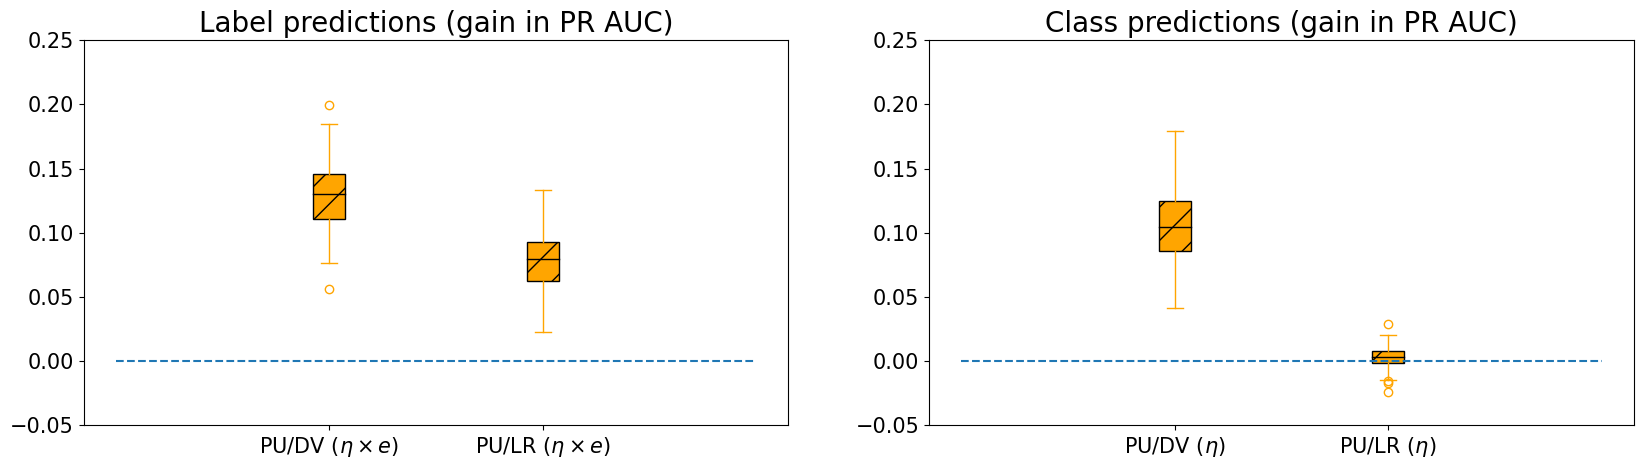

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
axes[0].set_title('Label predictions (gain in PR AUC)', fontsize=20)
results_impr(model_lr, 'PR_AUC', ax=axes[0], a='nc')
axes[1].set_title('Class predictions (gain in PR AUC)', fontsize=20)
results_impr(model_lr, 'PR_AUC', ax=axes[1], a='c')
axes[0].set_ylim(-0.05, 0.25)
axes[1].set_ylim(-0.05, 0.25)
axes[0].tick_params(labelsize=15)
axes[1].tick_params(labelsize=15)
plt.savefig('figures/PU_model_performances_impr.png', bbox_inches='tight')

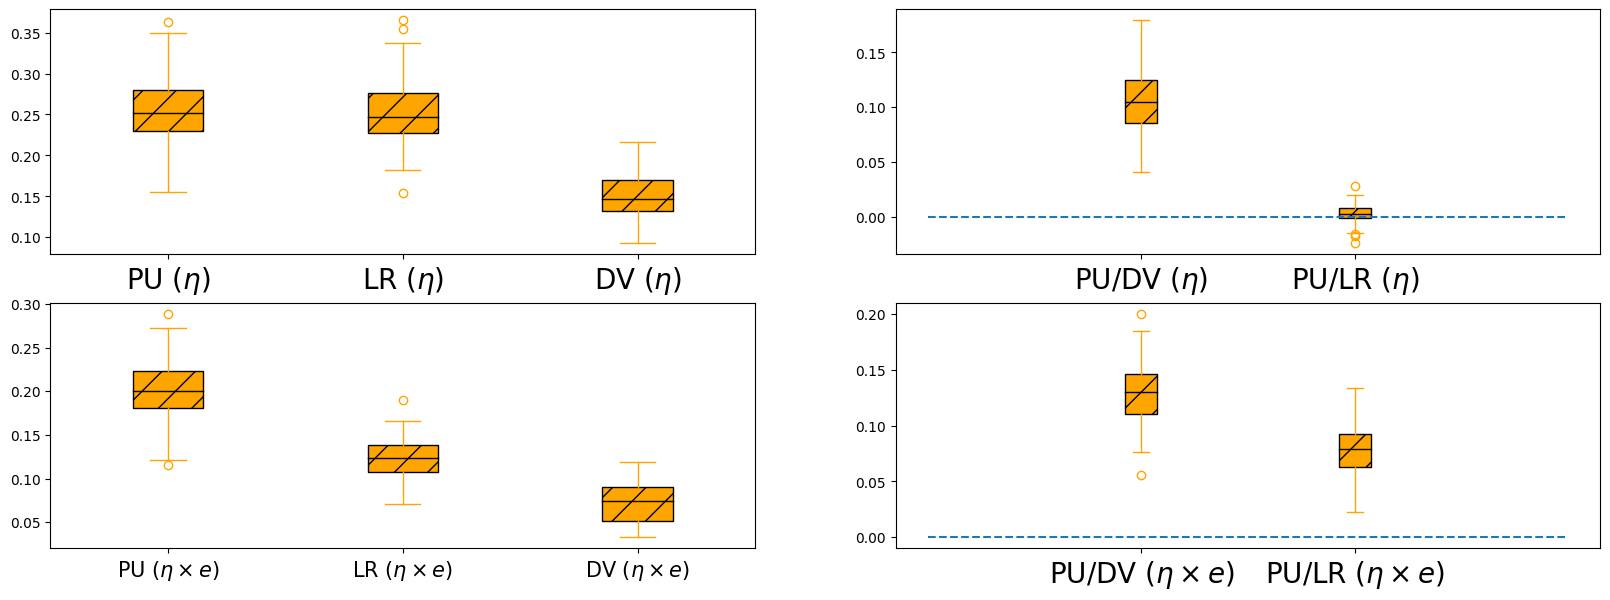

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,7))
results_table(model_lr, 'PR_AUC', ax=axes[0,0], a='c')
results_impr(model_lr, 'PR_AUC', ax=axes[0,1], a='c')
results_table(model_lr, 'PR_AUC', ax=axes[1,0], a='nc')
results_impr(model_lr, 'PR_AUC', ax=axes[1,1], a='nc')

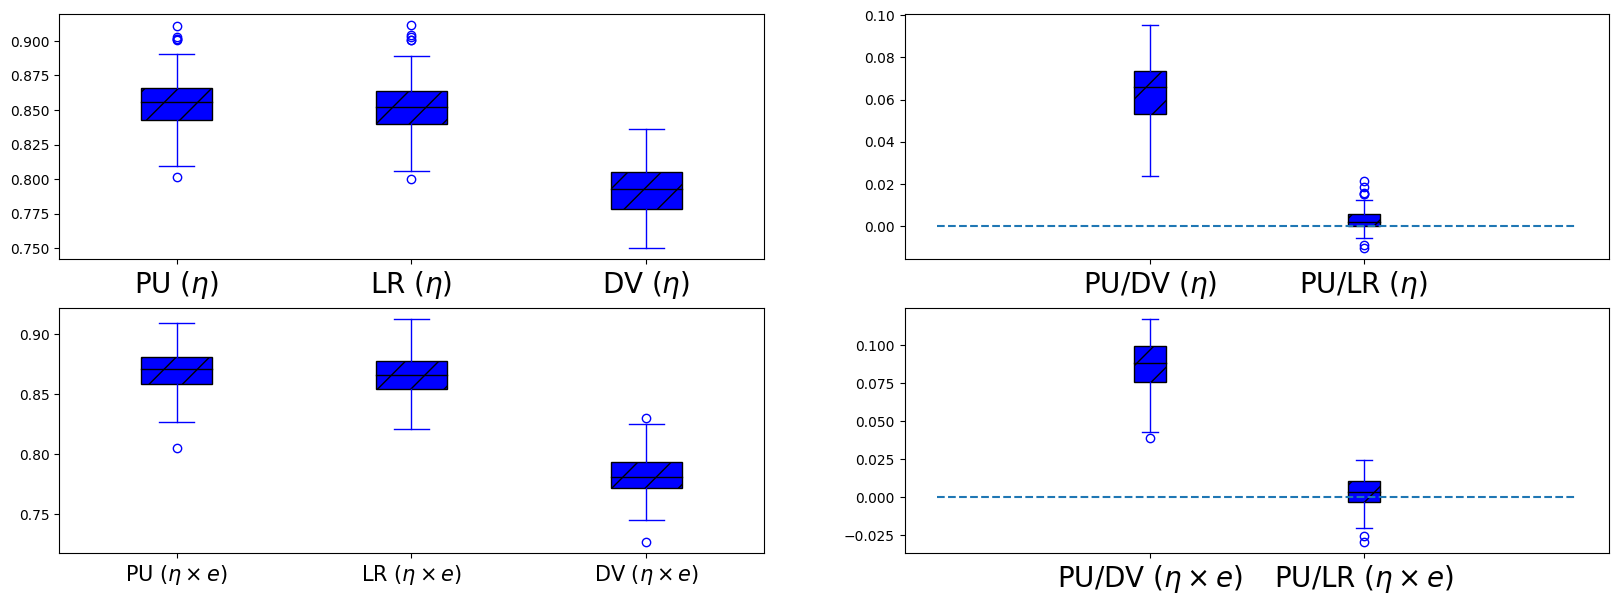

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,7))
results_table(model_lr, 'ROC_AUC', ax=axes[0,0], a='c')
results_impr(model_lr, 'ROC_AUC', ax=axes[0,1], a='c')
results_table(model_lr, 'ROC_AUC', ax=axes[1,0], a='nc')
results_impr(model_lr, 'ROC_AUC', ax=axes[1,1], a='nc')